In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import real_data_loader
import stylized_score
import torch
import train_fingan
import train_garch
import visualize_stylized_facts as vsf

## Set seeds for reconstruction of the results

In [2]:
# Set seeds.
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

#### Load Data

Filter out selected times and stocks

In [3]:
real_loader = real_data_loader.RealDataLoader(cache="../data/cache")
real_data = real_loader.get_timeseries(
    col_name="Adj Close", data_path="../data/raw_yahoo_data", update_all=False
)

Cached data found at ../data/cache/time_series_Adj_Close.csv.


Inspect data for missing information

In [4]:
N_STOCKS = 9216
nan_mask = ~np.isnan(real_data)  # returns pd.dataframe
num_non_nans: pd.DataFrame = np.sum(nan_mask, axis=0)
non_nan_orderd_stocks: pd.DataFrame = num_non_nans.sort_values(ascending=False)
# plt.plot(non_nan_orderd_stocks.values)
stocks = non_nan_orderd_stocks.iloc[non_nan_orderd_stocks.values >= N_STOCKS].index

In [5]:
# stocks = ["MSFT", "AAPL", "IBM", "ADBE", "ORCL", "INTC", "AMD", "HPQ"]
# stocks = ['MSFT']
first_date = real_data.index[-N_STOCKS]
real_data = real_data.loc[first_date:, stocks]
real_data = real_data.loc[:, np.all(~np.isnan(real_data), axis=0)]
assert np.all(~np.isnan(real_data))
print(f"Shape: {real_data.shape}")
print(f"Frist Date {real_data.index[0]:%Y-%m-%d}")
print(f"Last Date {real_data.index[-1]:%Y-%m-%d}")

Shape: (9216, 233)
Frist Date 1987-08-05
Last Date 2024-03-01


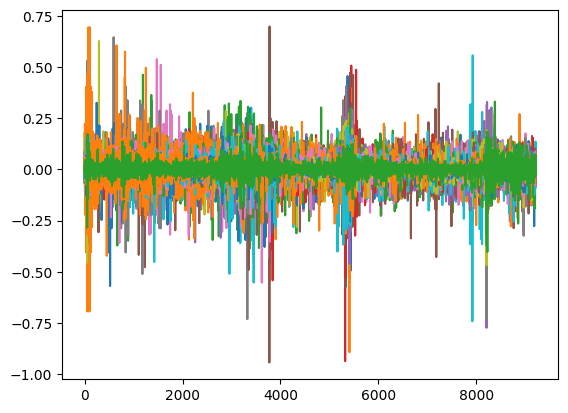

In [6]:
np_data = np.array(real_data)
np_ret = np.log(np_data[1:] / np_data[:-1])
np_ret[np.abs(np_ret) >= 2] = 0  # clean data
np_log_price = np.cumsum(np_ret, axis=0)
plt.plot(np_ret)
plt.show()

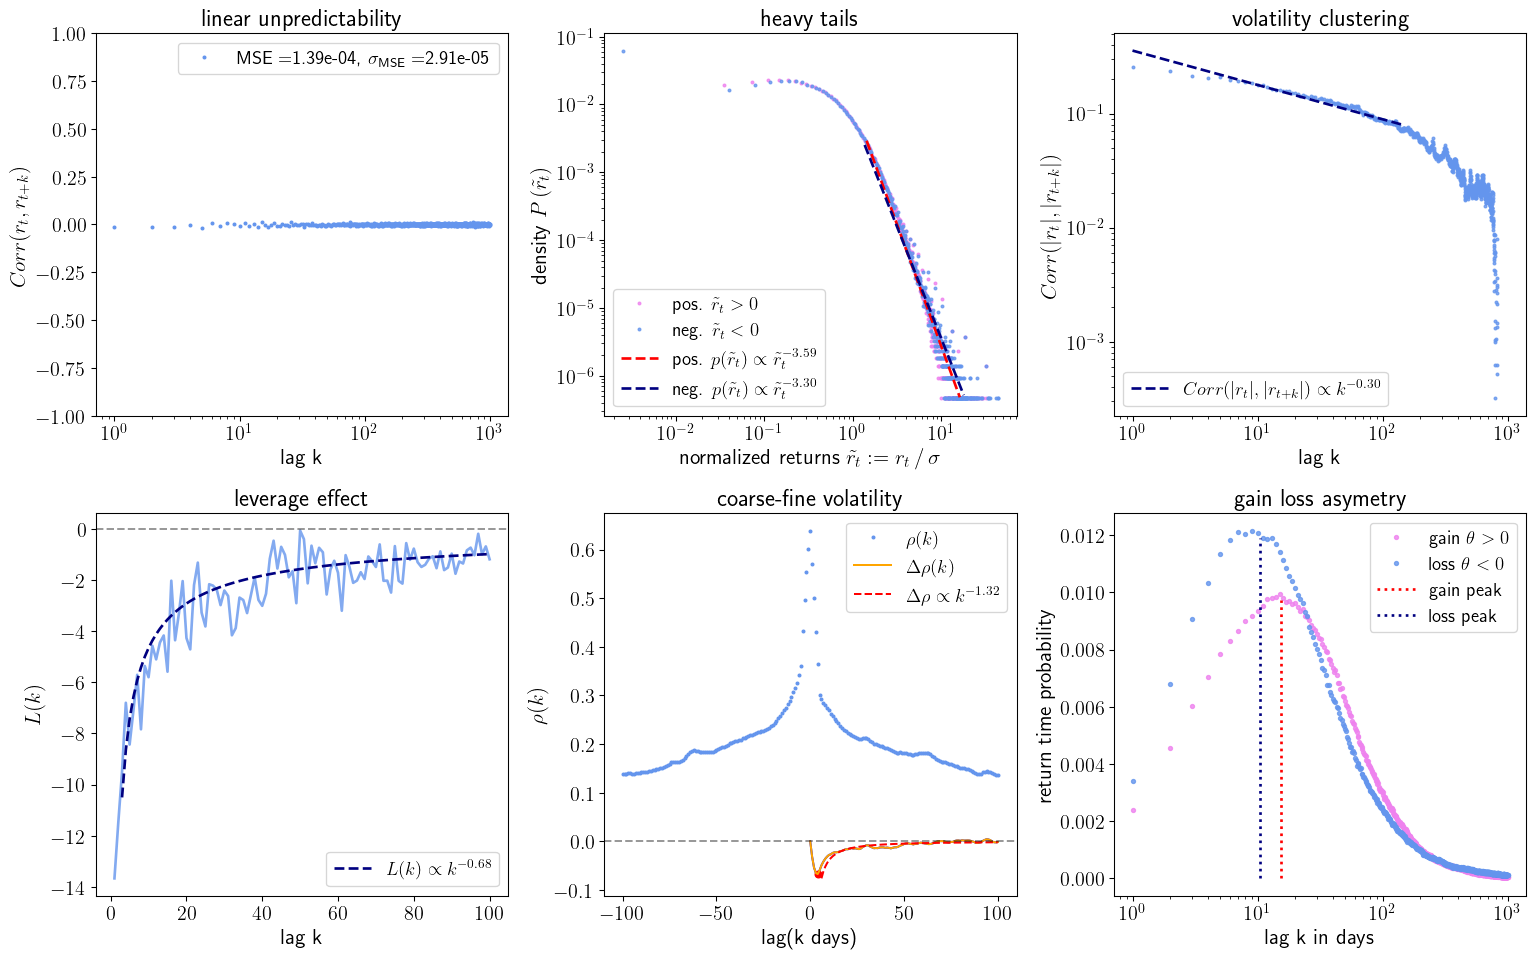

In [7]:
fig = vsf.visualize_stylized_facts(log_returns=np_ret)
# plt.savefig("/home/nico/edu/masterthesis/presentations/week16/figures/stf.png")
plt.show()

In [8]:
cache = "../data/cache/Garch_normal_3_3_2024_06_26-11_11_24"
garch_log_rets = train_garch.sample_garch(cache)
garch_log_rets = garch_log_rets[:, np.sum(np.isnan(garch_log_rets), axis=0) == 0]

/home/nico/edu/masterthesis/code/src/garch/train_garch.py:131: RuntimeWarning: invalid value encountered in log
  log_returns.append(np.log(return_simulation))


/home/nico/.cache/pypoetry/virtualenvs/synthetic-data-5lnic9a9-py3.11/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/nico/.cache/pypoetry/virtualenvs/synthetic-data-5lnic9a9-py3.11/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/nico/.cache/pypoetry/virtualenvs/synthetic-data-5lnic9a9-py3.11/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


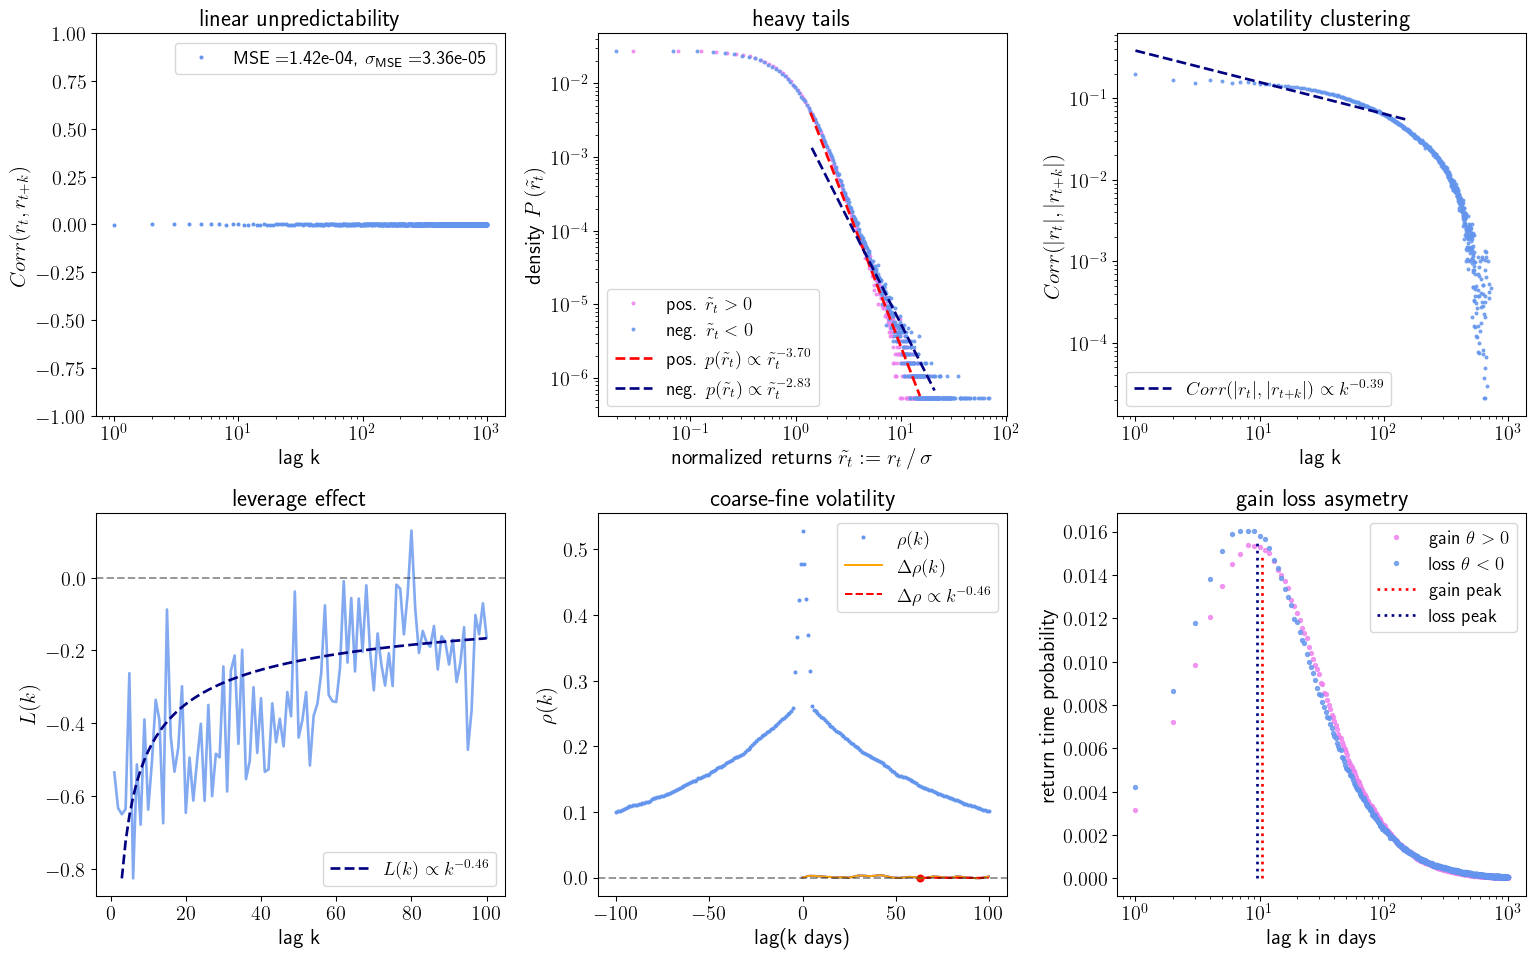

/home/nico/.cache/pypoetry/virtualenvs/synthetic-data-5lnic9a9-py3.11/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/nico/.cache/pypoetry/virtualenvs/synthetic-data-5lnic9a9-py3.11/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/nico/.cache/pypoetry/virtualenvs/synthetic-data-5lnic9a9-py3.11/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Real gl_real : (5.0,)
Real gl_syn : [1.0]


(1.0321459842078746,
 {'lin unpred': 0.13111090526684155,
  'heavy tails': 0.8774440835034031,
  'vol cluster': 0.7846464984189139,
  'lev effect': 1.183290592217883,
  'cf vol': 2.7529778944557015,
  'gain loss': 0.4634059313845047})

In [9]:
fig = vsf.visualize_stylized_facts(log_returns=garch_log_rets)
plt.show()
plt.close()
stylized_score.stylized_score(np_ret, garch_log_rets)

In [10]:
model_file = "/home/nico/fgt/final/model.pt"
fingan_log_rets = train_fingan.sample_fingan(model_file, seed=99)
fingan_log_rets = fingan_log_rets[:, np.sum(np.isnan(fingan_log_rets), axis=0) == 0]

TypeError: FinGan.__init__() got an unexpected keyword argument 'dtype'

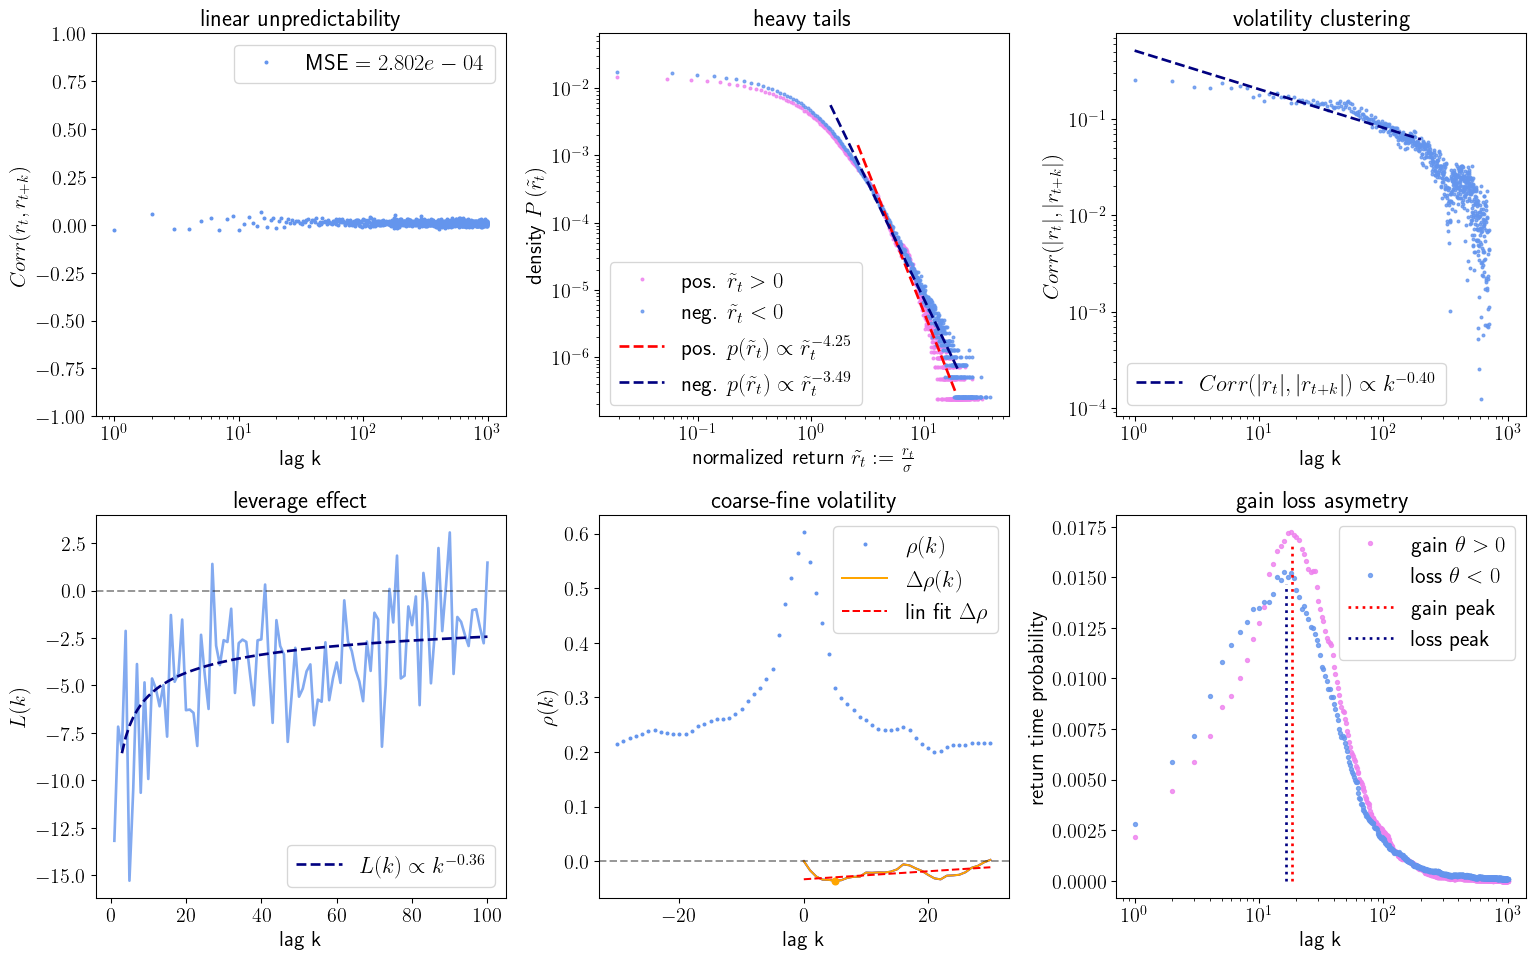

(4.1903230444733,
 {'lin unpred': 12.30367439902279,
  'heavy tails': 1.59752761087239,
  'vol cluster': 0.7689841057734581,
  'lev effect': 1.6899425103812638,
  'cf vol': 0.42033889705867544,
  'gain loss': 8.361470743731225})

In [ ]:
vsf.visualize_stylized_facts(log_returns=fingan_log_rets)
plt.show()
plt.close()
stylized_score.stylized_score(np_ret, fingan_log_rets)